In [8]:
! pip install --upgrade scikit-learn
! pip install --quiet fuzzywuzzy
! pip install --quiet python-levenshtein
! pip install --quiet diskcache
! pip install --quiet lime
! pip install --quiet torch
! pip install --quiet gcsfs
! pip install -e 'git://github.com/nandanrao/embed-software.git#egg=embed_software'

In [31]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import re
import attr
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from validation.data import dot_train_data, get_soc_n, get_dictionary, indeed_test_data
from embed_software.preprocess import *
from embed_software.utils import get_embeddings, embed_docs
from classification.embedding import PreEmbeddedVectorizer

pd.set_option('max_colwidth',50)
pd.set_option('display.width', 700)

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
SAMPLE_SIZE = 100000
SOC_LEVEL = 6

In [ ]:
X_train, y_train = dot_train_data(SOC_LEVEL)
X_test, y_test, ids = indeed_test_data('data/us/everything.csv', SAMPLE_SIZE, SOC_LEVEL)

In [3]:
from itertools import islice

with open('../abstracts-processed') as f:
    lines = f.readlines()
    lines = (l.strip() for l in lines)
    lines = islice(lines, 0, 500)
    lines = pd.Series(list(lines))

In [6]:
from toolz import dissoc

In [ ]:
model.embedders[0].net.conver(docs[i]).max(1).values

In [ ]:
overlapping.content[3001]

In [ ]:
i = 3011

_, words = embedding.embed_doc(overlapping.content[i], return_words=True)

idxs = np.argwhere(model.embedders[0].net.conver(docs[i]).max(1).values.detach().numpy() < 0.10)[:, 1]
np.array(words)[idxs]

In [746]:
X = np.array([model.embedders[0](d).detach().numpy() for d in docs])

In [169]:
title, company = zip(*[[int(x.numpy()) for x in l] for l in labels])

In [170]:
original = np.array([d.detach().numpy().mean(2).reshape(100,) for d in docs])

In [710]:
import seaborn as sns
from sklearn.manifold import MDS

In [750]:
X.shape

(5210, 100)

In [715]:
overlapping.category.shape

(5210,)

In [ ]:
idx = (np.abs(X.sum(1)) > 0.1)

dat = overlapping[idx]

pd.DataFrame(MDS(2).fit_transform(X.astype(np.float64)))

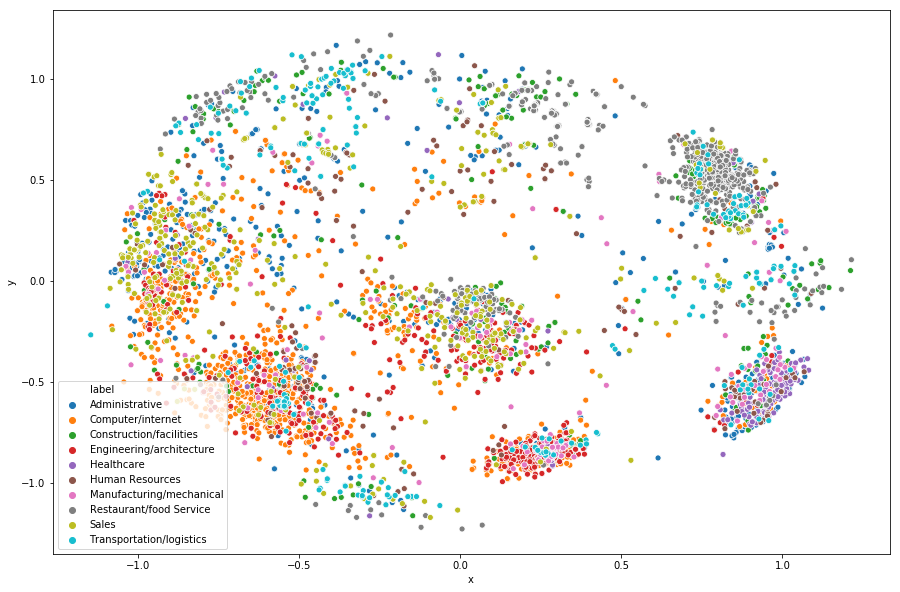

In [752]:
# add = pd.DataFrame(list(zip(overlapping.title.unique(), [0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0])), columns = ['title', 'soft'])
# oo = overlapping.merge(add, how='left', on='title')

sns.scatterplot(x = 'x', y = 'y', hue='label', data = pd.DataFrame(MDS(2).fit_transform(X.astype(np.float64)), columns = ['x', 'y']).assign(label = overlapping.category))

In [758]:
def simple_embed(embedding, doc):
    X = embedding.embed_doc(doc).sum(0)
    return X / np.linalg.norm(X)

X = np.array([simple_embed(embedding, d) for d in overlapping.content]) 

In [759]:
sns.scatterplot(x = 'x', y = 'y', hue='label', data = pd.DataFrame(MDS(2).fit_transform(X), columns = ['x', 'y']).assign(label = overlapping.category))

MemoryError: 

In [ ]:
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_predict, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score

model = LogisticRegression()

preds = cross_val_predict(model, X, overlapping, cv=KFold(3, shuffle=True))
accuracy_score(preds, title)

In [ ]:
model = Pipeline([('sentencespace_100_us', PreEmbeddedVectorizer('../abstracts-ss-100', 100, cache_dir='embed_cache')),
                  ('knn', KNeighborsClassifier(1, n_jobs=-1))])

model.fit(X_train, y_train)

In [8]:
def _get_soc_n(df, n):
    return (df.T
            .reset_index()
            .pipe(lambda df: df.assign(soc = df['index'].map(lambda i: str(i)[0:n])))
            .set_index('soc')
            .drop('index', 1)
            .groupby('soc').sum().T)


def get_pred(model, X):
    vals = model.predict_proba(X)
    df = pd.DataFrame(vals)
    df.columns = model.classes_
    n=3
    return _get_soc_n(df, n)

class UpscaleModel(LogisticRegression):
    def predict_soc_n(self, X, n):
        preds = self.predict_proba(X)
        df = pd.DataFrame(preds)
        df.columns = labels
        return self._get_soc_n(df, n)
    
    
def make_title_lookup(path, N):
    dot_codes = get_dictionary('', N).groupby('soc').first()
    d = dot_codes[f'desc_soc{N}'].to_dict()
    def lookup(code):
        try:
            return d[int(code)]
        except KeyError:
            return code
    return lookup

In [46]:
labels = np.unique(y_train)
lookup = make_title_lookup('', 3)

def get_soc_n(df, n):
    return (df.T
            .reset_index()
            .pipe(lambda df: df.assign(soc = df['index'].map(lambda i: str(i)[0:n])))
            .set_index('soc')
            .drop('index', 1)
            .groupby('soc')
            .sum().T
            .idxmax(1))

In [55]:
def print_preds(model, labels, target):
    preds = model.predict_proba(target)
    df = pd.DataFrame(preds)
    df.columns = labels

    res = [(lookup(cl),li) for cl,li in zip(get_soc_n(df, 3).values, target)]

    for title, desc in res:
        print(title)
        print(desc)
        print('\n')

In [104]:
print_preds(model, labels, lines[:25])

Material Moving Workers
flexible longitudinally continuous tape construction is disclosed for use in joining mating edges of juxtaposed members the tape having an like configuration transversely of its length to provide legs adapted to receive and be secured to the edges of the members to be joined	the tape is capable of serving as pliable hinge to permit articulation of the joined members or it may also serve simply as binding for joining members intended to be fixed relative to each other	the tape construction combines longitudinally continuous marginal web portions or carriers forming the extremities of the legs of the with longitudinally spaced strand or equivalent connector means running crosswise of and interconnecting pairs of marginal web portions	the connector means intersect and interlock forming the axis of the like configuration


Food Processing Workers
method of preserving perishable products	the method of packaging perishable products in container and insuring preservati

In [103]:
print_preds(model, labels, lines[1000:1025])

Textile, Apparel, and Furnishings Workers
method for production of hydroxyalkylglycol ethers	method for the production of hydroxyalkyl glycol ethers comprises reacting non terminal epoxides with ethylene glycol in the presence of an alkoxylation catalyst and saturated hydrocarbons in particular saturated aliphatic hydrocarbons as solvents


Other Installation, Maintenance, and Repair Occupations
removal and neutralisation of acid catalyst from products of cumene hydroperoxide cleavage	the mineral acid catalyst is removed from the products of cumene hydroperoxide cleavage by contact with an aqueous solution of an inorganic salt and an excess of an alkali metal hydroxide or phenate in first zone	suitably the aqueous solution contains sodium sulphate and sodium hydroxide or phenate	the aqueous layer is removed and the organic layer contacted in second zone with an aqueous solution comprising an inorganic salt and sufficient weak acid to decompose any phenate carried over from the first zo

In [105]:
print_preds(model, labels, lines[5000:5025])

Computer Occupations
use of hot spare drives to boost performance during nominal raid operation	method and apparatus for increasing performance in data processing system	the data processing system includes plurality of storage devices and backup storage device	the backup storage device is configured as log device	data is logged to the backup storage device after the backup storage device has been configured as log device	in response to failure of storage device within the plurality of storage devices the backup storage device is reconfigured to be used as replacement for the failed storage device


Computer Occupations
estimator program for estimating the availability of an application program that runs in cluster of at least two computers	an estimator program is disclosed which performs method steps for estimating the availability of an application program that runs on any computer in cluster of at least two computers	by the availability of an application program is herein meant the p

In [109]:
print_preds(model, labels, lines[5000:5025])

Other Production Occupations
thermo magnetic image recording methods and apparatus	magnetic image recording methods and apparatus employ magnetic recording medium susceptible to an image wise change of magnetization in response to thermal image patterns provided by image wise exposures of thermal image pattern generating device	the thermal device is subjected to repeated image wise exposures with each exposure including an exposure to an image part to which the thermal device is also exposed during another one of the exposures	the thermal device is moved relative to the recording medium between exposures and the image is magnetically recorded onto the recording medium with the aid of thermal image patterns generated by the exposures	in accordance with another aspect the mentioned thermal device is exposed at different spatial locations to each elemental area of the image	the exposed spatial locations as to each elemental image are brought into coincidence relative to the recording medi

In [111]:
print_preds(model, labels, lines[12000:12050])

Assemblers and Fabricators
battery of storage cells	the invention relates to semi open battery of storage cells each likely to evolve large volume of hydrogen more particularly during overcharge	battery according to the invention comprises an intermediate or dummy lid so located with respect to the regular lid of the battery to enable the inflammable gas flow generated in the cells to be isolated from the flow of fluid or gas serving for cooling of the electrical connections of the storage cells and thus avoiding or eliminating all danger of explosion


Material Moving Workers
blow molded gang type vent for multiple cell electric storage battery	dimensionally flexible one piece thermoplastic resinous hollow gang type vent with vent plugs for plurality of the filling wells of multiple cell battery is produced by blow molding technique


Vehicle and Mobile Equipment Mechanics, Installers, and Repairers
porous ceramic battery vent	fired porous ceramic battery vent having porosity and part

In [87]:
l = pd.concat([lines[:50], lines[1000:1050], lines[10000:10050], lines[-50:]])

In [ ]:
from sklearn.neighbors import NearestNeighbors

a = embed_docs('../abstracts-ss-100', '\n'.join(l))

nn = NearestNeighbors()
nn.fit(a)

In [99]:
def print_neighbors(nn, a, i):
    _, idxs = nn.kneighbors(a[i].reshape(1,-1), n_neighbors = 5)
    for i in idxs:
        print(l.values[i])

In [108]:
print_neighbors(nn, a, 150)

['multi way cache expansion circuit architecture\tan expandable set tag cache circuit for use with data cache memory comprises tag memory divided into first set and second set for storing under single address location first and second tag fields representative of first and second data respectively\tthe tag memory also stores first and second signals representative of which of the sets is the least recently used\tcomparator is responsive to tag field of an address representative of requested data as well as to first tag field output from the tag memory for producing an output signal indicative of match therebetween\tsecond comparator is responsive to the same tag field of the address and to second tag field output from the tag memory for producing an output signal indicative of match therebetween\tfirst logic gate is responsive to the first and second comparators for producing an output signal indicative of the availability of the requested data in the data cache memory\tsecond logic ga